In [35]:
import braintrust
from dataclasses import dataclass


@dataclass
class ExperimentConfig:
    experiment_id: str
    mode: str
    response_model: str
    model: str

    def get_labels(self):
        for row in braintrust.init(
            project="simple-qa", experiment=self.experiment_id, open=True
        ):
            if row["scores"] and row["metadata"]["score"]:
                yield row["metadata"]["score"] # This is the label

    def get_counts(self):
        counts = {}
        for label in self.get_labels():
            counts[label] = counts.get(label, 0) + 1
        
        return counts
    
configs = [
    ExperimentConfig(
        experiment_id="main-1730367644",
        mode="json",
        response_model="GeneratedResponse",
        model="gpt-4o-mini"
    ),
    ExperimentConfig(
        experiment_id="main-1730367677",
        mode="json",
        response_model="GeneratedResponseCOT",
        model="gpt-4o-mini"
    ),
    ExperimentConfig(
        experiment_id="main-1730367734",
        mode="tools",
        response_model="GeneratedResponse",
        model="gpt-4o-mini"
    ),
    ExperimentConfig(
        experiment_id="main-1730367770",
        mode="tools",
        response_model="GeneratedResponseCOT",
        model="gpt-4o-mini"
    ),
    ExperimentConfig(
        experiment_id="main-1730370652",
        mode="tools",
        response_model="GeneratedResponseCOT",
        model="gpt-4o"
    ),
    ExperimentConfig(
        experiment_id="main-1730370605",
        mode="tools",
        response_model="GeneratedResponse",
        model="gpt-4o"
    ),
    ExperimentConfig(
        experiment_id="main-1730370527",
        mode="json",
        response_model="GeneratedResponseCOT",
        model="gpt-4o"
    ),
    ExperimentConfig(
        experiment_id="main-1730370480",
        mode="json",
        response_model="GeneratedResponse",
        model="gpt-4o"
    ),
]


In [36]:
import pandas as pd

counts = []

for config in configs:
    config_counts = config.get_counts()
    total = sum(config_counts.values())
    counts.append({
        "mode": config.mode,
        "response_model": config.response_model,
        "model": config.model,
        "chain_of_thought": config.response_model.endswith("COT"),
        "correct": config_counts.get("CORRECT", 0)/total * 100,
        "incorrect": config_counts.get("INCORRECT", 0)/total * 100,
        "not_attempted": config_counts.get("NOT_ATTEMPTED", 0)/total * 100,
    })

df = pd.DataFrame(counts)
df.round(2)

,mode,response_model,model,chain_of_thought,correct,incorrect,not_attempted
0,json,GeneratedResponse,gpt-4o-mini,False,5.50,94.00,0.50
1,json,GeneratedResponseCOT,gpt-4o-mini,True,7.25,89.25,3.50
2,tools,GeneratedResponse,gpt-4o-mini,False,8.00,90.75,1.25
3,tools,GeneratedResponseCOT,gpt-4o-mini,True,6.50,90.75,2.75
4,tools,GeneratedResponseCOT,gpt-4o,True,28.00,64.25,7.75
5,tools,GeneratedResponse,gpt-4o,False,31.50,66.25,2.25
6,json,GeneratedResponseCOT,gpt-4o,True,26.50,62.25,11.25
7,json,GeneratedResponse,gpt-4o,False,31.75,65.00,3.25


In [42]:
import numpy as np
from collections import Counter

def bootstrap_samples(config: ExperimentConfig, n_samples: int = 1000):
    bootstrap_results = []
    items = list(config.get_labels()) # Convert generator to list

    # Sample with replacement n_samples times
    for _ in range(n_samples):
        sample = list(np.random.choice(items, size=len(items), replace=True))
        counts = Counter(sample)
        bootstrap_results.append({
            "correct": counts["CORRECT"],
            "incorrect": counts["INCORRECT"], 
            "not_attempted": counts["NOT_ATTEMPTED"],
        })

    # Finally we return a dataframe of means and standard deviations for each metric
    return pd.DataFrame(bootstrap_results)

In [49]:
import numpy as np

configs = [
    ExperimentConfig(
        experiment_id="main-1730370652",
        mode="tools",
        response_model="GeneratedResponseCOT",
        model="gpt-4o"
    ),
    ExperimentConfig(
        experiment_id="main-1730370527",
        mode="json",
        response_model="GeneratedResponseCOT",
        model="gpt-4o"
    ),
]

results = []
for config in configs:
    bootstraped_samples = bootstrap_samples(config)
    percentiles = bootstraped_samples.quantile([0.025, 0.975])
    results.append({
        "response_model": config.response_model,
        "model": config.model,
        "experiment_id": config.experiment_id,
        "mode": config.mode,
        **{
            f"{metric}": bootstraped_samples[metric].mean() for metric in bootstraped_samples.columns
        },
        **{
            f"{metric}_lower": percentiles.loc[0.025, metric] for metric in bootstraped_samples.columns
        },
        **{
            f"{metric}_upper": percentiles.loc[0.975, metric] for metric in bootstraped_samples.columns
        },
    })

df = pd.DataFrame(results)

In [54]:
df

,response_model,model,experiment_id,mode,correct,incorrect,not_attempted,correct_lower,incorrect_lower,not_attempted_lower,correct_upper,incorrect_upper,not_attempted_upper
0,GeneratedResponseCOT,gpt-4o,main-1730370652,tools,111.884,257.148,30.968,95.0,237.975,21.0,131.0,276.0,42.0
1,GeneratedResponseCOT,gpt-4o,main-1730370527,json,105.490,249.617,44.893,89.0,231.000,33.0,123.0,268.0,58.0


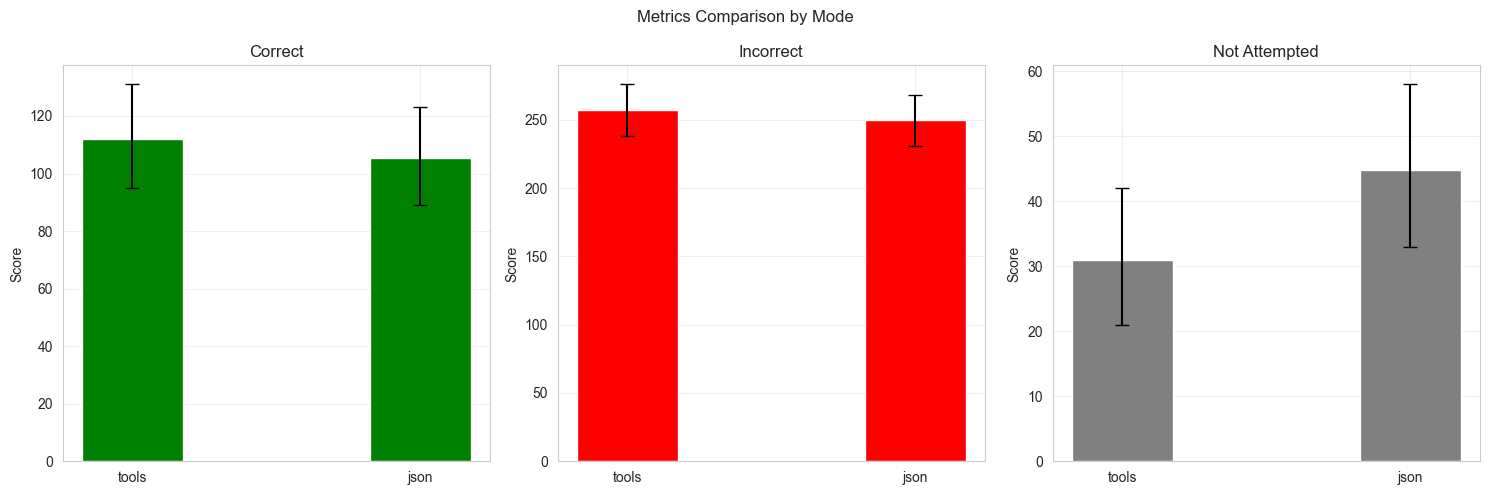

In [61]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['correct', 'incorrect', 'not_attempted']
colors = ['green', 'red', 'gray']

# Create subplots for each metric
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))
bar_width = 0.35

# Plot each metric in its own subplot
for i, (metric, color, ax) in enumerate(zip(metrics, colors, axes)):
    modes = df['mode'].values
    values = df[metric].values
    yerr_lower = values - df[f'{metric}_lower'].values
    yerr_upper = df[f'{metric}_upper'].values - values
    
    x = np.arange(len(modes))
    ax.bar(x, values, bar_width,
           color=color,
           yerr=[yerr_lower, yerr_upper],
           capsize=5)
    
    # Customize each subplot
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    ax.set_xticks(x)
    ax.set_xticklabels(modes, rotation=0)
    ax.grid(True, alpha=0.3)

plt.suptitle('Metrics Comparison by Mode')
plt.tight_layout()
plt.show()
